In [1]:
pip install pandas-profiling

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\statistics\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


In [2]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\statistics\AppData\Local\Programs\Python\Python38\python.exe -m pip install --upgrade pip' command.


ライブラリの読み込み

In [3]:
import numpy as np
import pandas as pd
import os
import pickle
import gc
# 分布の確認
import pandas_profiling as pdp 
# 可視化
import matplotlib.pyplot as plt 
# 前処理
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder 
# モデリング
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore")

# matplotlibで日本語表示したい場合はこれをinstallしてインポートする
# !pip install japanize-matplotlib
# import japanize_matplotlib
# %matplotlib inline

c:\Users\statistics\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\STATIS~1\AppData\Local\Temp/ipykernel_10096/4108074516.py:7: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pdp


ファイルの読み込み

In [4]:
df_train = pd.read_csv("../data/train.csv")

データセットの作成

In [5]:
x_train, y_train, id_train = df_train[['Pclass', 'Fare']], df_train[['Survived']], df_train[['PassengerId']] 

クロスバリデーションの場合

モデル学習、精度の評価

In [6]:
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': '0.1',
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain',
}

def train_cv(input_x, input_y, input_id, params, n_splits=5):

    metrics = []
    imp = pd.DataFrame()

    cv = list(StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123).split(input_x, input_y))

    for nfold in np.arange(n_splits):
        print("-"*20, nfold, "-"*20)
        idx_tr, idx_va = cv[nfold][0], cv[nfold][1]
        x_tr, y_tr = input_x.loc[idx_tr, :], input_y.loc[idx_tr, :]
        x_va, y_va = input_x.loc[idx_va, :], input_y.loc[idx_va, :]
        print(x_tr.shape, y_tr.shape)
        print(x_va.shape, y_va.shape)
        print(f"input_y:{input_y['Survived'].mean():.3f}, y_tr:{y_tr['Survived'].mean():.3f}, y_va:{y_va['Survived'].mean():.3f}")

        model = lgb.LGBMClassifier(**params)
        model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_va, y_va)], early_stopping_rounds=100, verbose=10)

        y_tr_pred = model.predict(x_tr)
        y_va_pred = model.predict(x_va)
        metric_tr = accuracy_score(y_tr, y_tr_pred)
        metric_va = accuracy_score(y_va, y_va_pred)
        print(f"[accuracy] tr: {metric_tr:.2f}, va: {metric_va:.2f}")

        metrics.append([nfold, metric_tr, metric_va])
        _imp = pd.DataFrame({'col': input_x.columns, 'imp': model.feature_importances_, 'nfold': nfold})
        imp = pd.concat([imp, _imp], axis=0, ignore_index=True)

    print("-"*20, 'result', "-"*20)
    metrics = np.array(metrics)
    print(metrics)

    print(f"[cv] tr: {metrics[:,1].mean():.2f}+-{metrics[:,1].std():.2f}, va: {metrics[:,2].mean():.2f}+-{metrics[:,2].std():.2f}")

    imp = imp.groupby('col')['imp'].agg(['mean', 'std'])
    imp.columns = ['imp', 'imp_std']
    imp = imp.reset_index(drop=False)

    print('Done.')

    return imp, metrics

モデルの学習・評価

In [7]:
imp, metrics = train_cv(x_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
(712, 2) (712, 1)
(179, 2) (179, 1)
input_y:0.384, y_tr:0.383, y_va:0.385
[10]	training's auc: 0.788155	valid_1's auc: 0.736957
[20]	training's auc: 0.805606	valid_1's auc: 0.731686
[30]	training's auc: 0.814213	valid_1's auc: 0.734256
[40]	training's auc: 0.82194	valid_1's auc: 0.731028
[50]	training's auc: 0.826838	valid_1's auc: 0.730632
[60]	training's auc: 0.832653	valid_1's auc: 0.732082
[70]	training's auc: 0.835966	valid_1's auc: 0.724045
[80]	training's auc: 0.839696	valid_1's auc: 0.71693
[90]	training's auc: 0.843037	valid_1's auc: 0.716206
[100]	training's auc: 0.844961	valid_1's auc: 0.716469
[110]	training's auc: 0.847218	valid_1's auc: 0.71726
[accuracy] tr: 0.72, va: 0.68
-------------------- 1 --------------------
(713, 2) (713, 1)
(178, 2) (178, 1)
input_y:0.384, y_tr:0.384, y_va:0.382
[10]	training's auc: 0.786679	valid_1's auc: 0.74873
[20]	training's auc: 0.800014	valid_1's auc: 0.752874
[30]	training's auc: 0.808685	vali

変数追加・データセット作成（"Age"のカラムを追加）

In [8]:
x_train, y_train, id_train = df_train[['Pclass', 'Fare', 'Age']], df_train[['Survived']], df_train[['PassengerId']] 
print(x_train.shape, y_train.shape, id_train.shape)

(891, 3) (891, 1) (891, 1)


学習・評価（新しいデータセットの利用）

In [9]:
imp, metrics = train_cv(x_train, y_train, id_train, params, n_splits=5)

-------------------- 0 --------------------
(712, 3) (712, 1)
(179, 3) (179, 1)
input_y:0.384, y_tr:0.383, y_va:0.385
[10]	training's auc: 0.834706	valid_1's auc: 0.700264
[20]	training's auc: 0.85567	valid_1's auc: 0.712451
[30]	training's auc: 0.87421	valid_1's auc: 0.726285
[40]	training's auc: 0.887181	valid_1's auc: 0.722398
[50]	training's auc: 0.897644	valid_1's auc: 0.723847
[60]	training's auc: 0.907515	valid_1's auc: 0.726153
[70]	training's auc: 0.91427	valid_1's auc: 0.72747
[80]	training's auc: 0.92064	valid_1's auc: 0.722332
[90]	training's auc: 0.926598	valid_1's auc: 0.725099
[100]	training's auc: 0.931588	valid_1's auc: 0.721937
[110]	training's auc: 0.935818	valid_1's auc: 0.721014
[120]	training's auc: 0.939264	valid_1's auc: 0.722991
[130]	training's auc: 0.941968	valid_1's auc: 0.721673
[140]	training's auc: 0.945789	valid_1's auc: 0.720224
[150]	training's auc: 0.949043	valid_1's auc: 0.719697
[160]	training's auc: 0.952164	valid_1's auc: 0.719433
[accuracy] tr: 0

説明変数の重要度の算出

In [10]:
imp.sort_values('imp', ascending=False, ignore_index=True)

,col,imp,imp_std
0,Fare,547.621958,270.958097
1,Age,436.497719,247.807858
2,Pclass,299.843845,103.344422


##### 4.7.3　ベースラインの評価

ベースラインの評価の観点
- モデルの精度
- 誤差の分布
- 予測値の分布

In [11]:
x_tr, x_va2, y_tr, y_va2 = train_test_split(x_train, y_train, test_size=0.2, shuffle=True, stratify=y_train, random_state=123)
print(x_tr.shape, y_tr.shape)
print(x_va2.shape, y_va2.shape)

(712, 3) (712, 1)
(179, 3) (179, 1)


In [12]:
x_tr1, x_va1, y_tr1, y_va1 = train_test_split(x_tr, y_tr, test_size=0.2, shuffle=True, stratify=y_tr, random_state=789)
print(x_tr1.shape, y_tr1.shape)
print(x_va1.shape, y_va1.shape)

(569, 3) (569, 1)
(143, 3) (143, 1)


In [13]:
# ハイパーパラメータ
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': '0.1',
    'num_leaves': 16,
    'n_estimators': 100000,
    'random_state': 123,
    'importance_type': 'gain',
}

model = lgb.LGBMClassifier(**params)
model.fit(x_tr1, y_tr1, eval_set=[(x_tr1, y_tr1), (x_va1, y_va1)], early_stopping_rounds=100, verbose=10)

[10]	training's auc: 0.850074	valid_1's auc: 0.745868
[20]	training's auc: 0.862431	valid_1's auc: 0.743492
[30]	training's auc: 0.882263	valid_1's auc: 0.752996
[40]	training's auc: 0.898985	valid_1's auc: 0.756818
[50]	training's auc: 0.910139	valid_1's auc: 0.756715
[60]	training's auc: 0.919718	valid_1's auc: 0.75093
[70]	training's auc: 0.926919	valid_1's auc: 0.748967
[80]	training's auc: 0.933264	valid_1's auc: 0.751343
[90]	training's auc: 0.937799	valid_1's auc: 0.75124
[100]	training's auc: 0.943608	valid_1's auc: 0.75124
[110]	training's auc: 0.947646	valid_1's auc: 0.748554
[120]	training's auc: 0.950887	valid_1's auc: 0.746074
[130]	training's auc: 0.95469	valid_1's auc: 0.743802


LGBMClassifier(importance_type='gain', learning_rate='0.1', metric='auc',
               n_estimators=100000, num_leaves=16, objective='binary',
               random_state=123)

In [14]:
y_va1_pred = model.predict(x_va1)
y_va2_pred = model.predict(x_va2)

In [15]:
print(f"[検証データ] acc: {accuracy_score(y_va1, y_va1_pred):.4f}")
print(f"[ベースライン検証データ] acc: {accuracy_score(y_va2, y_va2_pred):.4f}")

[検証データ] acc: 0.7063
[ベースライン検証データ] acc: 0.6872


In [16]:
print('検証データ')
print(confusion_matrix(y_va1, y_va1_pred))
print(confusion_matrix(y_va1, y_va1_pred, normalize='all'))
print('ベースライン検証データ')
print(confusion_matrix(y_va2, y_va2_pred))
print(confusion_matrix(y_va2, y_va2_pred, normalize='all'))

検証データ
[[76 12]
 [30 25]]
[[0.53146853 0.08391608]
 [0.20979021 0.17482517]]
ベースライン検証データ
[[89 21]
 [35 34]]
[[0.4972067  0.11731844]
 [0.19553073 0.18994413]]


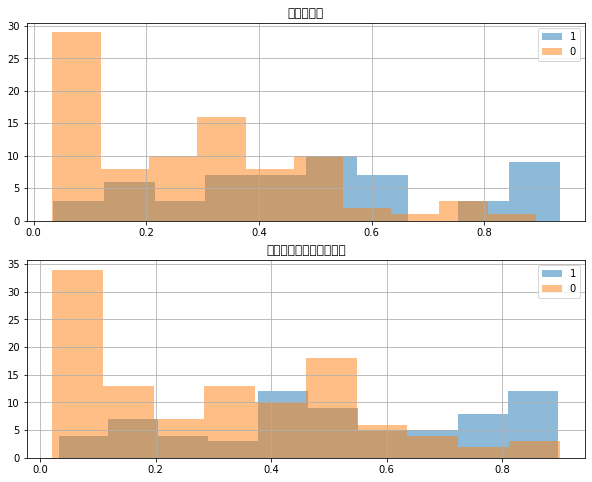

In [17]:
# 予測値の確率値算出
y_va1_pred_prob = model.predict_proba(x_va1)[:,1]
y_va2_pred_prob = model.predict_proba(x_va2)[:,1]

# 確率値をヒストグラムで可視化
fig = plt.figure(figsize=(10,8))
# 検証データ
fig.add_subplot(2, 1, 1)
plt.title("検証データ")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va1_pred_prob[np.array(y_va1).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()
# ベースライン検証データ
fig.add_subplot(2, 1, 2)
plt.title("ベースライン検証データ")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==1], bins=10, alpha=0.5, label="1")
plt.hist(y_va2_pred_prob[np.array(y_va2).reshape(-1)==0], bins=10, alpha=0.5, label="0")
plt.grid()
plt.legend()

### 4.8　モデル推論

##### 4.8.1　推論用データセット作成

In [18]:
df_test = pd.read_csv('../data/test.csv')
x_test = df_test[['Pclass', 'Fare', 'Age']]
id_test = df_test[['PassengerId']]

##### 4.8.2　学習済モデルを用いた推論

In [19]:
# 学習モデルによる推論
y_test_pred = model.predict(x_test)

In [20]:
# 提出用ファイルの作成
df_submit = pd.DataFrame({'PassengerId':id_test['PassengerId'], 'Survived':y_test_pred})
display(df_submit.head(5))
df_submit.to_csv('../data/submission_baseline.csv', index=None)

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


### 5.2　データの前処理

##### 5.2.1　データの確認（詳細）
- 要約統計量の一括確認
- 指定した要約統計量の確認
- 種類ごとの件数確認（主にカテゴリ変数）
- 便利な集計ライブラリ（pandas_profiling）

要約統計量の一括確認

In [21]:
# 要約統計量の一括確認（数値データ）
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [22]:
# 要約統計量の一括確認（カテゴリ変数）
df_train.describe(exclude='number').T

,count,unique,top,freq
Name,891,891,"Braund, Mr. Owen Harris",1
Sex,891,2,male,577
Ticket,891,681,347082,7
Cabin,204,147,B96 B98,4
Embarked,889,3,S,644


指定した要約統計量の確認

In [23]:
df_train[['Fare']].agg(['mean']).T

,mean
Fare,32.204208


In [24]:
df_train[['Fare']].agg(['mean', 'std', 'min', 'max']).T

,mean,std,min,max
Fare,32.204208,49.693429,0.0,512.3292


In [25]:
df_train[['Fare']].agg(['dtype', 'count', 'nunique', 'mean', 'std', 'min', 'max']).T

,dtype,count,nunique,mean,std,min,max
Fare,float64,891,248,32.204208,49.693429,0.0,512.3292


In [26]:
df_train.agg(['dtype', 'count', 'nunique', 'mean', 'std', 'min', 'max']).T

,dtype,count,nunique,mean,std,min,max
PassengerId,int64,891,891,446.0,257.353842,1,891
Survived,int64,891,2,0.383838,0.486592,0,1
Pclass,int64,891,3,2.308642,0.836071,1,3
Name,object,891,891,NaN,NaN,"Abbing, Mr. Anthony","van Melkebeke, Mr. Philemon"
Sex,object,891,2,NaN,NaN,female,male
Age,float64,714,88,29.699118,14.526497,0.42,80.0
SibSp,int64,891,7,0.523008,1.102743,0,8
Parch,int64,891,7,0.381594,0.806057,0,6
Ticket,object,891,681,NaN,NaN,110152,WE/P 5735
Fare,float64,891,248,32.204208,49.693429,0.0,512.3292


種類ごとの件数確認

In [27]:
df_train['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

便利な集計ライブラリ（Pandas_profiling）

In [28]:
pdp.ProfileReport(df_train)

ModuleNotFoundError: No module named 'ipywidgets'

##### 5.2.2　欠損値の把握・補間
- 欠損値の確認
- 欠損値の補間方法：数値データ
- 欠損値の補間方法：カテゴリデータ

欠損値の確認方法

In [29]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

欠損値の補間方法（数値データ）

In [30]:
# ０埋め
df_train['Age_fillna_0'] = df_train['Age'].fillna(0)
df_train.loc[df_train['Age'].isnull(), ['Age', 'Age_fillna_0']].head()

,Age,Age_fillna_0
5,NaN,0.0
17,NaN,0.0
19,NaN,0.0
26,NaN,0.0
28,NaN,0.0


In [31]:
# 平均値補間
df_train['Age_fillna_mean'] = df_train['Age'].fillna(df_train['Age'].mean())
df_train.loc[df_train['Age'].isnull(), ['Age', 'Age_fillna_mean']].head()

,Age,Age_fillna_mean
5,NaN,29.699118
17,NaN,29.699118
19,NaN,29.699118
26,NaN,29.699118
28,NaN,29.699118


欠損値の補間方法（カテゴリデータ）

In [32]:
# 空白埋め
df_train['Cabin_fillna_space'] = df_train['Cabin'].fillna("")
df_train.loc[df_train['Cabin'].isnull(), ['Cabin', 'Cabin_fillna_space']].head()

,Cabin,Cabin_fillna_space
0,NaN,
2,NaN,
4,NaN,
5,NaN,
7,NaN,


In [33]:
# 最頻値補間
df_train['Cabin_fillna_mode'] = df_train['Cabin'].fillna(df_train['Cabin'].mode()[0])
df_train.loc[df_train['Cabin'].isnull(), ['Cabin', 'Cabin_fillna_mode']].head()

,Cabin,Cabin_fillna_mode
0,NaN,B96 B98
2,NaN,B96 B98
4,NaN,B96 B98
5,NaN,B96 B98
7,NaN,B96 B98


##### 5.2.3　外れ値の検出・補正
- 一般的な知識やドメイン知識による外れ値の判定
- 分布を推定して外れ値を判定する方法
- 外れ値の補正方法

一般的な知識やドメイン知識による外れ値の判定

In [34]:
df_train['Age'].agg(['min', 'max'])

min     0.42
max    80.00
Name: Age, dtype: float64

<AxesSubplot:>

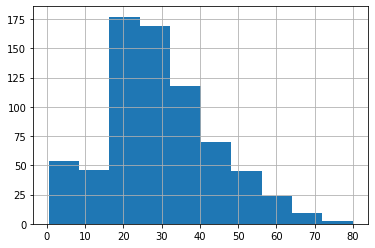

In [35]:
df_train['Age'].hist()

分布を推定して外れ値を判定する方法

In [36]:
# 四分位範囲を利用した外れ値検出方法
quartile = df_train['Age'].quantile(q=0.75) - df_train['Age'].quantile(q=0.25)
print('四分位範囲:', quartile)
print('下限値:', df_train['Age'].quantile(q=0.25) - quartile * 1.5)
print('上限値:', df_train['Age'].quantile(q=0.75) + quartile * 1.5)

四分位範囲: 17.875
下限値: -6.6875
上限値: 64.8125


外れ値の補正方法
- レコードごと除外する
- 欠損値に変換する
- ヒアリングして外れ値を正しい値に変換する
- 他のデータから推定して補正する
- 何もしない

In [37]:
# 外れ値を欠損値に変換
df_train.loc[df_train['Age'] < 0, 'Age'] = np.nan

##### 5.2.4　標準化・正規化

標準化

In [38]:
# 標準化（sklearnを使用しないver）
value_mean = df_train['Fare'].mean()
value_std = df_train['Fare'].std(ddof=0) # 母集団の標準偏差を利用する場合
# value_std = df_train['Fare'].std() # 標本の標準偏差を利用する場合
print("mean:", value_mean, ", std:", value_std)

df_train['Fare_standard'] = (df_train['Fare'] - value_mean) / value_std
df_train[['Fare', 'Fare_standard']].head()

mean: 32.204207968574636 , std: 49.6655344447741


,Fare,Fare_standard
0,7.2500,-0.502445
1,71.2833,0.786845
2,7.9250,-0.488854
3,53.1000,0.420730
4,8.0500,-0.486337


In [39]:
# 標準化（sklearnを使用するver）
std = StandardScaler()
std.fit(df_train[['Fare']])
print("mean:", std.mean_[0], ", std:", np.sqrt(std.var_[0]))

df_train['Fare_standard'] = std.transform(df_train[['Fare']])
df_train[['Fare', 'Fare_standard']].head()

mean: 32.204207968574636 , std: 49.6655344447741


,Fare,Fare_standard
0,7.2500,-0.502445
1,71.2833,0.786845
2,7.9250,-0.488854
3,53.1000,0.420730
4,8.0500,-0.486337


正規化

In [40]:
# 正規化（sklearnを使用しないver）
value_min = df_train['Fare'].min()
value_max = df_train['Fare'].max()
print('min:', value_min, ', max:', value_max)
df_train['Fare_normalize'] = (df_train['Fare'] - value_min) / (value_max - value_min)
df_train[['Fare', 'Fare_normalize']].head()

min: 0.0 , max: 512.3292


,Fare,Fare_normalize
0,7.2500,0.014151
1,71.2833,0.139136
2,7.9250,0.015469
3,53.1000,0.103644
4,8.0500,0.015713


In [41]:
# 正規化（sklearnを使用するver）
mms = MinMaxScaler()
mms.fit(df_train[['Fare']])
print('min:', mms.data_min_[0], ', max:', mms.data_max_[0])
df_train['Fare_normalize'] = mms.transform(df_train[['Fare']])
df_train[['Fare', 'Fare_normalize']].head()

min: 0.0 , max: 512.3292


,Fare,Fare_normalize
0,7.2500,0.014151
1,71.2833,0.139136
2,7.9250,0.015469
3,53.1000,0.103644
4,8.0500,0.015713


### 5.3　特徴量作成
- 仮説ベースの特徴量作成
- 機械的な特徴量作成

##### 5.3.1　単変数：数値
- 対数変換
- 累乗・指数関数・逆数
- 離散化
- 欠損かどうかで0/1

対数変換

In [42]:
df_train['Fare_log'] = np.log(df_train['Fare'] + 1e-5)
df_train[['Fare', 'Fare_log']].head()

,Fare,Fare_log
0,7.2500,1.981003
1,71.2833,4.266662
2,7.9250,2.070024
3,53.1000,3.972177
4,8.0500,2.085673


累乗・指数関数・逆数

In [43]:
df_train['Fare_square'] = df_train['Fare'].apply(lambda x: x**2)
df_train['Fare_exp'] = df_train['Fare'].apply(lambda x: np.exp(x))
df_train['Fare_reciprocal'] = df_train['Fare'].apply(lambda x: 1 / (x + 1e-3))
df_train[['Fare', 'Fare_square', 'Fare_exp', 'Fare_reciprocal']].head()

,Fare,Fare_square,Fare_exp,Fare_reciprocal
0,7.2500,52.562500,1.408105e+03,0.137912
1,71.2833,5081.308859,9.077031e+30,0.014028
2,7.9250,62.805625,2.765564e+03,0.126167
3,53.1000,2819.610000,1.150898e+23,0.018832
4,8.0500,64.802500,3.133795e+03,0.124208


離散化

In [44]:
df_train['Age_bin'] = pd.cut(df_train['Age'],
                            bins=[0, 10, 20, 30, 40, 50, 100],
                            right=False,
                            labels=['10代未満', '10代', '20代', '30代', '40代', '50代以上'], 
                            duplicates='raise',
                            include_lowest=True
                            )
df_train['Age_bin'] = df_train['Age_bin'].astype(str)
df_train[['Age', 'Age_bin']].head()

,Age,Age_bin
0,22.0,20代
1,38.0,30代
2,26.0,20代
3,35.0,30代
4,35.0,30代


欠損かどうかで0/1に変換

In [45]:
df_train['Age_na'] = df_train['Age'].isnull()*1
df_train[['Age', 'Age_na']].head(7)

,Age,Age_na
0,22.0,0
1,38.0,0
2,26.0,0
3,35.0,0
4,35.0,0
5,NaN,1
6,54.0,0


##### 5.3.2　単変数：カテゴリ変数
- One Hot Encoding
- Count Encoding
- Label Encoding
- 欠損かどうかで0/1に変換

One Hot Encoding

In [46]:
# one-hot-encoding
ohe_embarked = OneHotEncoder(sparse=False)
ohe_embarked.fit(df_train[['Embarked']])

tmp_embarked = pd.DataFrame(
    ohe_embarked.transform(df_train[['Embarked']]),
    columns=[f"Embarked_{i}" for i in ohe_embarked.categories_[0]]
)

df_train = pd.concat([df_train, tmp_embarked], axis=1)
df_train[['Embarked', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Embarked_nan']].head()

,Embarked,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan
0,S,0.0,0.0,1.0,0.0
1,C,1.0,0.0,0.0,0.0
2,S,0.0,0.0,1.0,0.0
3,S,0.0,0.0,1.0,0.0
4,S,0.0,0.0,1.0,0.0


In [47]:
df_ohe = pd.get_dummies(df_train[['Embarked', 'Sex']], dummy_na=True, drop_first=False)
df_ohe.head()

,Embarked_C,Embarked_Q,Embarked_S,Embarked_nan,Sex_female,Sex_male,Sex_nan
0,0,0,1,0,0,1,0
1,1,0,0,0,1,0,0
2,0,0,1,0,1,0,0
3,0,0,1,0,1,0,0
4,0,0,1,0,0,1,0


Count Encoding

In [48]:
ce_Embarked = df_train['Embarked'].value_counts().to_dict()
print(ce_Embarked)
df_train['Embarked_ce'] = df_train['Embarked'].map(ce_Embarked)
df_train[['Embarked', 'Embarked_ce']].head()

{'S': 644, 'C': 168, 'Q': 77}


,Embarked,Embarked_ce
0,S,644.0
1,C,168.0
2,S,644.0
3,S,644.0
4,S,644.0


Label Encoding

In [49]:
le_Embarked = LabelEncoder()
le_Embarked.fit(df_train['Embarked'])
df_train['Embarked_le'] = le_Embarked.transform(df_train['Embarked'])
df_train[['Embarked', 'Embarked_le']].head(6)

,Embarked,Embarked_le
0,S,2
1,C,0
2,S,2
3,S,2
4,S,2
5,Q,1


欠損かどうかで0/1に変換

In [50]:
df_train['Embarked_na'] = df_train['Embarked'].isnull()*1
df_train.loc[df_train['Embarked'].isnull(), ['Embarked', 'Embarked_na']].head()

,Embarked,Embarked_na
61,NaN,1
829,NaN,1


##### 5.3.3　２変数組み合わせ（数値×数値）

In [51]:
df_train['SibSp_+_Parch'] = df_train['SibSp'] + df_train['Parch']
df_train[['SibSp', 'Parch', 'SibSp_+_Parch']].head(10)

,SibSp,Parch,SibSp_+_Parch
0,1,0,1
1,1,0,1
2,0,0,0
3,1,0,1
4,0,0,0
5,0,0,0
6,0,0,0
7,3,1,4
8,0,2,2
9,1,0,1


##### 5.3.4　２変数組み合わせ（数値×カテゴリ変数）

In [52]:
df_agg = df_train.groupby('Sex')['Fare'].agg(['mean']).reset_index()
df_agg.columns = ['Sex', 'mean_Fare_by_Sex']
print('集約テーブル')
display(df_agg)

df_train = pd.merge(df_train, df_agg, on='Sex', how='left')
print('結合後テーブル')
display(df_train[['Sex', 'Fare', 'mean_Fare_by_Sex']].head())

集約テーブル


,Sex,mean_Fare_by_Sex
0,female,44.479818
1,male,25.523893


結合後テーブル


,Sex,Fare,mean_Fare_by_Sex
0,male,7.2500,25.523893
1,female,71.2833,44.479818
2,female,7.9250,44.479818
3,female,53.1000,44.479818
4,male,8.0500,25.523893


In [53]:
# df_train['mean_Fare_by_Sex'] = df_train.goupby('Sex')['Fare'].transform('mean')
# df_train[['Sex', 'Fare', 'mean_Fare_by_Sex']].head()
# でも可

##### 5.3.5　２変数組み合わせ：カテゴリ変数×カテゴリ変数

- カテゴリ変数×カテゴリ変数：出現回数
- カテゴリ変数×カテゴリ変数：出現割合
- カテゴリ変数×カテゴリ変数：条件式を用いた変換

出現回数

In [54]:
df_tbl = pd.crosstab(df_train['Sex'], df_train['Embarked'])
print('集約テーブル（クロス集計）')
display(df_tbl)

df_tbl = df_tbl.reset_index()
df_tbl = pd.melt(df_tbl, id_vars='Sex', value_name='count_Sex_x_Embarked')
print('集約テーブル（縦持ち変換後）')
display(df_tbl)

df_train = pd.merge(df_train, df_tbl, on=['Sex', 'Embarked'], how='left')
print('結合後テーブル')
df_train[['Sex', 'Embarked', 'count_Sex_x_Embarked']].head()

集約テーブル（クロス集計）


Embarked,C,Q,S
Sex,,,
female,73,36,203
male,95,41,441


集約テーブル（縦持ち変換後）


,Sex,Embarked,count_Sex_x_Embarked
0,female,C,73
1,male,C,95
2,female,Q,36
3,male,Q,41
4,female,S,203
5,male,S,441


結合後テーブル


,Sex,Embarked,count_Sex_x_Embarked
0,male,S,441.0
1,female,C,73.0
2,female,S,203.0
3,female,S,203.0
4,male,S,441.0


In [55]:
df_train['count_Sex_x_Embarked'] = df_train.groupby(['Sex', 'Embarked'])['PassengerId'].transform('count')
df_train[['Sex', 'Embarked', 'count_Sex_x_Embarked']].head()

,Sex,Embarked,count_Sex_x_Embarked
0,male,S,441.0
1,female,C,73.0
2,female,S,203.0
3,female,S,203.0
4,male,S,441.0


出現割合

In [56]:
df_tbl = pd.crosstab(df_train['Sex'], df_train['Embarked'], normalize='index')
print('集約テーブル（行方向の和で割る）')
display(df_tbl)

df_tbl = df_tbl.reset_index()
df_tbl = pd.melt(df_tbl, id_vars='Sex', value_name='rate_Sex_x_Embarked')
print('集約テーブル（縦持ち変換後）')
display(df_tbl)

df_train = pd.merge(df_train, df_tbl, on=['Sex', 'Embarked'], how='left')
print('結合後テーブル')
df_train[['Sex', 'Embarked', 'rate_Sex_x_Embarked']].head()

集約テーブル（行方向の和で割る）


Embarked,C,Q,S
Sex,,,
female,0.233974,0.115385,0.650641
male,0.164645,0.071057,0.764298


集約テーブル（縦持ち変換後）


,Sex,Embarked,rate_Sex_x_Embarked
0,female,C,0.233974
1,male,C,0.164645
2,female,Q,0.115385
3,male,Q,0.071057
4,female,S,0.650641
5,male,S,0.764298


結合後テーブル


,Sex,Embarked,rate_Sex_x_Embarked
0,male,S,0.764298
1,female,C,0.233974
2,female,S,0.650641
3,female,S,0.650641
4,male,S,0.764298


条件式を用いた変換

In [57]:
df_train['Sex=male_&_Embarked=S'] = np.where((df_train['Sex']=='male') & (df_train['Embarked']=='S'), 1, 0)
df_train[['Sex', 'Embarked', 'Sex=male_&_Embarked=S']].head()

,Sex,Embarked,Sex=male_&_Embarked=S
0,male,S,1
1,female,C,0
2,female,S,0
3,female,S,0
4,male,S,1


##### 5.3.6　時系列データ

- ラグ特徴量
- ウィンドウ特徴量
- 累積特徴量

ラグ特徴量

In [58]:
# １行シフト
df1 = pd.DataFrame({'date':pd.date_range('2021-01-01', '2021-01-10'), 'weather':['sunny', 'sunny', 'rainy', 'cloudy', 'cloudy', 'sunny', 'rainy', 'sunny', 'sunny', 'sunny']})
df1['weather_shift1'] = df1['weather'].shift(1)
df1

,date,weather,weather_shift1
0,2021-01-01,sunny,NaN
1,2021-01-02,sunny,sunny
2,2021-01-03,rainy,sunny
3,2021-01-04,cloudy,rainy
4,2021-01-05,cloudy,cloudy
5,2021-01-06,sunny,cloudy
6,2021-01-07,rainy,sunny
7,2021-01-08,sunny,rainy
8,2021-01-09,sunny,sunny
9,2021-01-10,sunny,sunny


In [59]:
# １行目に生じる欠損値を補間
df1['weather_shift1'] = df1['weather_shift1'].interpolate(method='bfill') # bfillで次の行の値で補間，ffillで最終行の値で補間
df1

,date,weather,weather_shift1
0,2021-01-01,sunny,sunny
1,2021-01-02,sunny,sunny
2,2021-01-03,rainy,sunny
3,2021-01-04,cloudy,rainy
4,2021-01-05,cloudy,cloudy
5,2021-01-06,sunny,cloudy
6,2021-01-07,rainy,sunny
7,2021-01-08,sunny,rainy
8,2021-01-09,sunny,sunny
9,2021-01-10,sunny,sunny


In [60]:
# IDごとに１行シフト
df2 = pd.DataFrame({'id':['A']*3 + ['B']*2 + ['C']*4, 'date':['2021-04-02', '2021-04-10', '2021-04-25', '2021-04-18', '2021-04-19', '2021-04-01', '2021-04-04', '2021-04-09', '2021-04-12'], 'money':[1000, 2000, 900, 4000, 1800, 900, 1200, 1100, 2900]})
df2['date'] = pd.to_datetime(df2['date'], format="%Y-%m-%d")
df2['money_shift1'] = df2.groupby('id')['money'].shift(1)
df2

,id,date,money,money_shift1
0,A,2021-04-02,1000,NaN
1,A,2021-04-10,2000,1000.0
2,A,2021-04-25,900,2000.0
3,B,2021-04-18,4000,NaN
4,B,2021-04-19,1800,4000.0
5,C,2021-04-01,900,NaN
6,C,2021-04-04,1200,900.0
7,C,2021-04-09,1100,1200.0
8,C,2021-04-12,2900,1100.0


In [62]:
# ラグ特徴量（経過日数）
df2['date_shift1'] = df2.groupby('id')['date'].shift(1)
df2['days_elapsed'] = df2['date'] - df2['date_shift1']
df2['days_elapsed'] = df2['days_elapsed'].dt.days
df2

,id,date,money,money_shift1,date_shift1,days_elapsed
0,A,2021-04-02,1000,NaN,NaT,NaN
1,A,2021-04-10,2000,1000.0,2021-04-02,8.0
2,A,2021-04-25,900,2000.0,2021-04-10,15.0
3,B,2021-04-18,4000,NaN,NaT,NaN
4,B,2021-04-19,1800,4000.0,2021-04-18,1.0
5,C,2021-04-01,900,NaN,NaT,NaN
6,C,2021-04-04,1200,900.0,2021-04-01,3.0
7,C,2021-04-09,1100,1200.0,2021-04-04,5.0
8,C,2021-04-12,2900,1100.0,2021-04-09,3.0


ウィンドウ特徴量

In [64]:
# ウィンドウ特徴量
df3 = pd.DataFrame({'date':pd.date_range('2021-01-01', '2021-01-10'), 'temperature':[8, 10, 12, 11, 9, 10, 12, 7, 9, 10]})
df3['temperature_window3'] = df3['temperature'].rolling(window=3).mean()
df3

,date,temperature,temperature_window3
0,2021-01-01,8,NaN
1,2021-01-02,10,NaN
2,2021-01-03,12,10.000000
3,2021-01-04,11,11.000000
4,2021-01-05,9,10.666667
5,2021-01-06,10,10.000000
6,2021-01-07,12,10.333333
7,2021-01-08,7,9.666667
8,2021-01-09,9,9.333333
9,2021-01-10,10,8.666667


In [65]:
# ウィンドウ特徴量（IDごと）
df4 = pd.DataFrame({'id': ['A']*3 + ['B']*2 + ['C']*4, 'date': ['2021-04-02', '2021-04-10', '2021-04-25', '2021-04-18', '2021-04-19', '2021-04-01', '2021-04-04', '2021-04-09', '2021-04-12'], 'money': [1000, 2000, 900, 4000, 1800, 900, 1200, 1100, 2900]})
df4['date'] = pd.to_datetime(df4['date'], format='%Y-%m-%d')
df4['money_shift1'] = df4.groupby('id')['money'].apply(lambda x: x.rolling(window=2).mean())
df4


,id,date,money,money_shift1
0,A,2021-04-02,1000,NaN
1,A,2021-04-10,2000,1500.0
2,A,2021-04-25,900,1450.0
3,B,2021-04-18,4000,NaN
4,B,2021-04-19,1800,2900.0
5,C,2021-04-01,900,NaN
6,C,2021-04-04,1200,1050.0
7,C,2021-04-09,1100,1150.0
8,C,2021-04-12,2900,2000.0


累積特徴量

In [67]:
# 累積特徴量
df5 = pd.DataFrame({'date':pd.date_range('2021-01-01', '2021-01-10'), 'flag_rain':[0, 0, 1, 0, 0, 0, 1, 0, 0, 0]})
df5['flag_rain_cumsum'] = df5['flag_rain'].cumsum()
df5

,date,flag_rain,flag_rain_cumsum
0,2021-01-01,0,0
1,2021-01-02,0,0
2,2021-01-03,1,1
3,2021-01-04,0,1
4,2021-01-05,0,1
5,2021-01-06,0,1
6,2021-01-07,1,2
7,2021-01-08,0,2
8,2021-01-09,0,2
9,2021-01-10,0,2


In [68]:
# 累積特徴量（IDごと）
df6 = pd.DataFrame({'id': ['A']*3 + ['B']*2 + ['C']*4, 'date': ['2021-04-02', '2021-04-10', '2021-04-25', '2021-04-18', '2021-04-19', '2021-04-01', '2021-04-04', '2021-04-09', '2021-04-12'], 'money': [1000, 2000, 900, 4000, 1800, 900, 1200, 1100, 2900]})
df6['date']=pd.to_datetime(df4['date'], format = '%Y-%m-%d')
df6['money_cumsum'] = df6.groupby('id')['money'].cumsum()
df6

,id,date,money,money_cumsum
0,A,2021-04-02,1000,1000
1,A,2021-04-10,2000,3000
2,A,2021-04-25,900,3900
3,B,2021-04-18,4000,4000
4,B,2021-04-19,1800,5800
5,C,2021-04-01,900,900
6,C,2021-04-04,1200,2100
7,C,2021-04-09,1100,3200
8,C,2021-04-12,2900,6100


##### 5.3.7　テキストデータ
- Bag of Words
- TF-IDF
- word2vec
-  BERT

Bag of Words（単語の出現回数）

In [70]:
# Bag of Wordsによるベクトル化
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
# vec = CountVectorizer() # 全単語を特徴量にする場合
vec = CountVectorizer(min_df=20)    # 10個しか出現しないレアなワードを除外

vec.fit(df_train['Name'])

df_name = pd.DataFrame(vec.transform(df_train['Name']).toarray(), columns=vec.get_feature_names())
print(df_name.shape)
df_name.head()

(891, 12)


,charles,george,henry,james,john,mary,master,miss,mr,mrs,thomas,william
0,0,0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,1,0,0,0,0,0,1,0,0,1


In [83]:
# 日本語のBag of Wordsを計算するときは, まず単語に区切ることが必要
# MeCabのKaggle分析環境へのインストールとインポート
!apt-get install -y mecab libmecab-dev mecab-ipadic-utf8
!pip install mecab-python3
os.environ['MECABRC']= "/etc/mecabrc"
import MeCab

'apt-get' �́A�����R�}���h�܂��͊O���R�}���h�A
����\�ȃv���O�����܂��̓o�b�` �t�@�C���Ƃ��ĔF������Ă��܂���B


You should consider upgrading via the 'c:\users\statistics\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [86]:
# Bag of Wordsによる日本語のベクトル化
print('サンプルデータ:')
df_text = pd.DataFrame({'text':['今日は雨ですね。天気予報では明日も雨です。', '雨なので傘を持って行った方がいいです。', '天気予報によると明後日は晴れのようです。']})
display(df_text)

print('形態素解析+分かち書き:')
wakati = MeCab.Tagger('-Owakati')
df_text['text_wakati'] = df_text['text'].apply(lambda x: wakati.parse(x).replace("\n", ""))
display(df_text)

print('Bag of Wordsによるベクトル化')
vec = CountVectorizer()
vec.fit(df_text['text_wakati'])
df_text_vec = pd.DataFrame(vec.transform(df_text['text_wakati'].toarray(), columns=vec.get_feature_names()))
df_text_vec.head()

サンプルデータ:


,text
0,今日は雨ですね。天気予報では明日も雨です。
1,雨なので傘を持って行った方がいいです。
2,天気予報によると明後日は晴れのようです。


形態素解析+分かち書き:


RuntimeError: 
----------------------------------------------------------

Failed initializing MeCab. Please see the README for possible solutions:

    https://github.com/SamuraiT/mecab-python3#common-issues

If you are still having trouble, please file an issue here, and include the
ERROR DETAILS below:

    https://github.com/SamuraiT/mecab-python3/issues

issueを英語で書く必要はありません。

------------------- ERROR DETAILS ------------------------
arguments: -Owakati
[ifs] no such file or directory: /etc/mecab
----------------------------------------------------------


多分，MeCabがうまくインストールされていないのか

### 5.4　データセット作成

##### 5.4.1　特徴量選択の方法
- フィルター法（filter method）
- ラッパー法（wrapper method）
- 組み込み法（embedded method）

##### 5.4.2　ラッパー法の進め方
1. 特徴量を追加作成
2. 追加した特徴量を加えたデータセットを作成
3. モデル学習をして精度評価
4. 精度が上がれば採用, 下がれば不採用